# Exploring Pricing Optimization with Machine Learning

In this notebook, we will implement a model to understand the mechanics of pricing optimization using machine learning. Google published a [blog post](https://cloud.google.com/blog/products/ai-machine-learning/price-optimization-using-vertex-ai-forecast) where they used a synthetic dataset with prices and sales for various items. However, their demo focused on the AutoML platform, and they did not share any details on the model itself, only the results from the model were shared.

Our goal is to reproduce the results from Google using a **Long Short-Term Memory (LSTM) based recurrent neural network**.


## High-Level Overview

1. **Download and ingest data**
2. **Frame the problem**:
    - Given price history and sales history for the last 28 days, can we estimate the sales for the next 14 days, for various price ranges (i.e., given the history, if I set the price as X, what is the expected demand)?
3. **Build an encoder-decoder LSTM based architecture** where the decoder takes in a price and outputs the demand (i.e., sales for the next 14 days).
4. **Compute sales for the next 14 days** for a product, given the price that we want to set (i.e., estimate the demand for our price).
5. **Estimate the optimal price** that maximizes profit.


<h3>IMPORTS</h3>

In [31]:
#@title
import requests
from google.colab import drive
drive.mount('/content/drive') 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3>DATA INGESTION</h3>

In [32]:
#@title
#Download the sample synthetic datasets
def download_file(url, save_path):
  response = requests.get(url)
  with open(save_path, 'wb') as f:
      f.write(response.content)
  return

In [33]:
#@title
#The authors of this blog post (https://cloud.google.com/blog/products/ai-machine-learning/price-optimization-using-vertex-ai-forecast) 
#have shared a synthetic dataset whose characteristics are similar to real world data

train_url = 'https://drive.google.com/uc?export=download&id=1QU2YEGyqsnjnpdX1wFQRUyeAzdeoRrMq'
pred_url = 'https://drive.google.com/uc?export=download&id=1iM-x6Xk9Ebgk78nb0LGLZn1-Qa874dL1'

train_path = 'prices_train.csv'
pred_path = 'prices_pred.csv'

download_file(train_url, train_path)
download_file(pred_url, pred_path)

In [35]:
#@title
prices = pd.read_csv('prices_train.csv', parse_dates=['date'])
prices = prices.drop(columns=['id', 'sku_name'])
prices['day_of_week'] = prices['date'].dt.dayofweek
prices['month_of_year'] = prices['date'].dt.month
rearrange = [col for col in prices.columns if col != 'sales'] + ['sales']
prices = prices[rearrange]
prices = prices.sort_values(by=['sku_id', 'date'])

<h3> SAMPLE DATA FROM ONE SKU </h3>

In [36]:
#@title
prices[prices['sku_id']==0]

,date,sku_id,price,gender,category,brand,collection,price_tier,style,cost,day_of_week,month_of_year,sales
0,2018-06-24,0,1.8,female,jeans,brand_2,P,middle,sport,43.63,6,6,423
1,2018-06-25,0,1.4,female,jeans,brand_2,P,middle,sport,43.63,0,6,1251
2,2018-06-26,0,1.4,female,jeans,brand_2,P,middle,sport,43.63,1,6,1054
3,2018-06-27,0,1.4,female,jeans,brand_2,P,middle,sport,43.63,2,6,830
4,2018-06-28,0,1.4,female,jeans,brand_2,P,middle,sport,43.63,3,6,715
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2020-06-16,0,1.3,female,jeans,brand_2,P,middle,sport,43.63,1,6,1625
724,2020-06-17,0,1.3,female,jeans,brand_2,P,middle,sport,43.63,2,6,1234
725,2020-06-18,0,1.3,female,jeans,brand_2,P,middle,sport,43.63,3,6,1099
726,2020-06-19,0,1.3,female,jeans,brand_2,P,middle,sport,43.63,4,6,1268


<h3> PREPARE DATA FOR THE ML MODEL </h3>

In [37]:
#@title
product_ids = prices['sku_id'].unique()

# Create a 80:20 train/validation split using date as the threshold
# Calculate the date threshold for each product
thresholds = {}
for product_id in product_ids:
    product_data = prices[prices['sku_id'] == product_id]
    threshold_date = product_data['date'].quantile(0.8)
    thresholds[product_id] = threshold_date

# Split the dataframe into train and test datasets
train = prices[prices.apply(lambda x: x['date'] < thresholds[x['sku_id']], axis=1)]
test = prices[prices.apply(lambda x: x['date'] >= thresholds[x['sku_id']], axis=1)]

In [38]:
#@title
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

HISTORY = 28 # Use the historical pricing for the previous HISTORY days
FORECAST = 14 # Predict the sales for the next FORECAST days
BATCH_SIZE = 32


def generate_data(df, product_id):
    product_df = df[df['sku_id']==product_id]
    product_df = product_df.sort_values(by='date')

    i = np.random.randint(0, product_df.shape[0] - HISTORY - FORECAST, 1)[0]
    X1 = product_df.iloc[i:i+HISTORY].drop(columns=['date', 'sku_id'])
    d1 = product_df.iloc[i:i+HISTORY]['date']
    X2 = product_df.iloc[i+HISTORY:i+HISTORY+FORECAST].drop(columns=['date', 'sku_id'])
    y = product_df.iloc[i+HISTORY:i+HISTORY+FORECAST]['sales']
    d2 = product_df.iloc[i+HISTORY:i+HISTORY+FORECAST]['date']
    return X1, X2, y, d1, d2



# Normalization and one hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['cost', 'price', 'sales']),
        ('cat', OneHotEncoder(), ['gender', 'category', 'brand', 'collection', 'price_tier', 'style', 'day_of_week', 'month_of_year'])
    ])
preprocessor.fit(train.drop(columns=['date', 'sku_id']))


# Generate the dataset in batches
def batch_gen(df):
  while True:
      np.random.shuffle(product_ids)
      for i in range(0, len(product_ids), BATCH_SIZE):
          batch_product_ids = product_ids[i:i+BATCH_SIZE]
          X1_batch, X2_batch, y_batch = [], [], []
          for product_id in batch_product_ids:
              X1, X2, y, _, _ = generate_data(df, product_id)
              X1 = preprocessor.transform(X1).toarray()
              X2 = preprocessor.transform(X2).toarray()
              y = X2[:,2]
              X2 = np.delete(X2, 2, axis=1) #Sales are in the 3rd column, we need to drop them from the decoder inputs, as we are predicting these

              X1_batch.append(X1)
              X2_batch.append(X2)
              y_batch.append(y)

          # Apply the column transformer on the input data
          X1_batch = np.array(X1_batch)
          X2_batch = np.array(X2_batch)
          y_batch = np.array(y_batch)
          yield [np.array(X1_batch), np.array(X2_batch)], np.array(y_batch)

In [39]:
#@title
train_gen = batch_gen(train)
test_gen = batch_gen(test)
tx, ty = next(train_gen)

In [40]:
#@title
tx[0].shape, tx[1].shape, ty.shape

((32, 28, 43), (32, 14, 42), (32, 14))

<h3> DEFINE AND TRAIN THE MODEL </h3>

In [12]:
#@title
import math
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

n_features = tx[0].shape[2] # number of features in your data, including sales
decoder_n_features = tx[1].shape[2] # number of features in the decoder input data, excluding sales

# Encoder
encoder_inputs = Input(shape=(HISTORY, n_features))
encoder_lstm_1 = LSTM(64, return_sequences=True)(encoder_inputs)
encoder_lstm_2 = LSTM(64, return_state=True)
_, encoder_state_h, encoder_state_c = encoder_lstm_2(encoder_lstm_1)
encoder_states = [encoder_state_h, encoder_state_c]

# Decoder
decoder_inputs = Input(shape=(FORECAST, decoder_n_features))
decoder_lstm_1 = LSTM(64, return_sequences=True)
decoder_lstm_2 = LSTM(64, return_sequences=True)
decoder_dense_1 = Dense(32, activation='relu')
decoder_dense_2 = Dense(1, activation='sigmoid')

x = decoder_lstm_1(decoder_inputs, initial_state=encoder_states)
x = decoder_lstm_2(x)
decoder_outputs = decoder_dense_2(decoder_dense_1(x))

# Model
encoder_decoder_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
encoder_decoder_model.compile(optimizer='adam', loss='mse')


# Set the training parameters
epochs = 100
steps_per_epoch = math.ceil(len(product_ids) / BATCH_SIZE)

# Train the model
history = encoder_decoder_model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data = test_gen,
    validation_steps = steps_per_epoch
)

encoder_decoder_model.save('/content/drive/My Drive/enc_decoder/')

Epoch 1/100
13/13 [==============================] - 30s 2s/step - loss: 0.0833 - val_loss: 0.0259
Epoch 2/100
13/13 [==============================] - 18s 1s/step - loss: 0.0233 - val_loss: 0.0251
Epoch 3/100
13/13 [==============================] - 19s 2s/step - loss: 0.0172 - val_loss: 0.0197
Epoch 4/100
13/13 [==============================] - 17s 1s/step - loss: 0.0162 - val_loss: 0.0186
Epoch 5/100
13/13 [==============================] - 17s 1s/step - loss: 0.0155 - val_loss: 0.0198
Epoch 6/100
13/13 [==============================] - 17s 1s/step - loss: 0.0143 - val_loss: 0.0180
Epoch 7/100
13/13 [==============================] - 18s 1s/step - loss: 0.0159 - val_loss: 0.0175
Epoch 8/100
13/13 [==============================] - 17s 1s/step - loss: 0.0137 - val_loss: 0.0168
Epoch 9/100
13/13 [==============================] - 18s 1s/step - loss: 0.0136 - val_loss: 0.0172
Epoch 10/100
13/13 [==============================] - 17s 1s/step - loss: 0.0137 - val_loss: 0.0179
Epoch 11/

<h3> (OPTIONAL) LOAD A SAVED MODEL </h3>

In [41]:
#@title
#from tensorflow import keras
#encoder_decoder_model = keras.models.load_model('/content/drive/My Drive/enc_decoder/')

<h3> COMPARE MODEL PREDICTIONS TO TRUE SALES FOR UNSEEN DATA </h3>

1/1 [==============================] - 0s 31ms/step


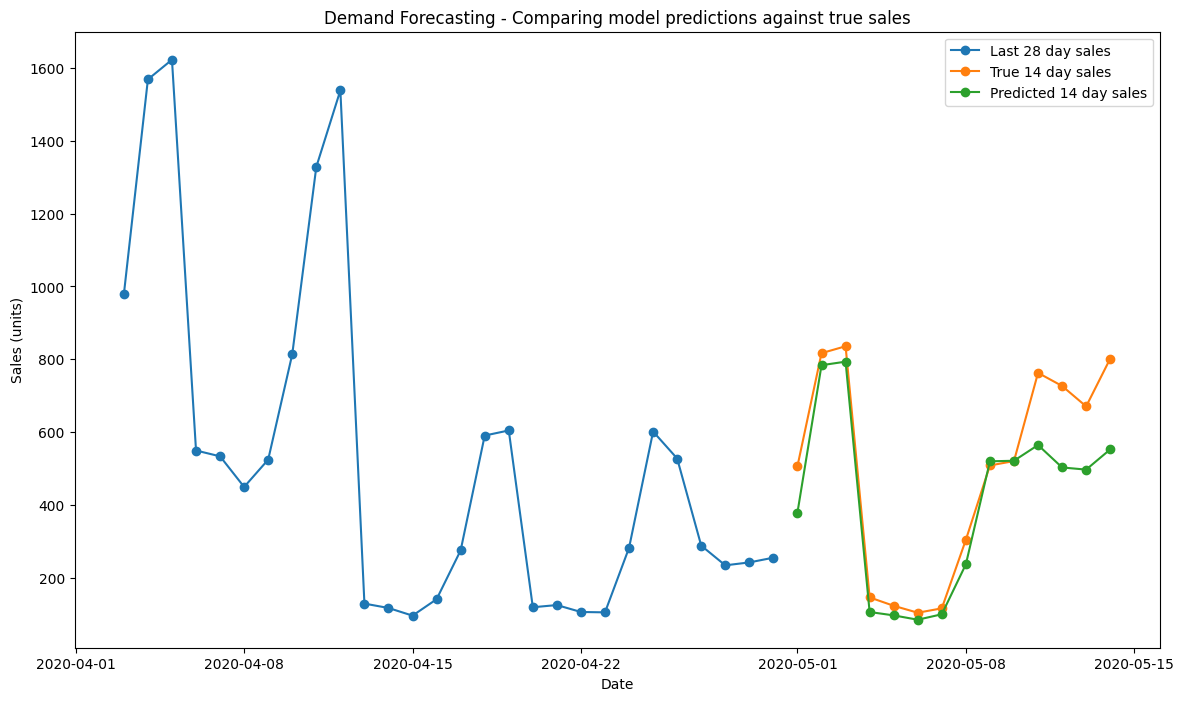

In [61]:
#@title
#Pick a random product_id from the test data, and compare its predictions to the true sales
X1, X2, y, d1, d2 = generate_data(test, 300)
X1['date'] = d1
X2['date'] = d2
X1_input = preprocessor.transform(X1).toarray()
X2_input = preprocessor.transform(X2).toarray()
y = X2_input[:,2]
X2_input = np.delete(X2_input, 2, axis=1)
X1_input = np.expand_dims(X1_input, axis=0)
X2_input = np.expand_dims(X2_input, axis=0)
py = encoder_decoder_model.predict([X1_input, X2_input])
X2['predicted'] = (py[0]*(preprocessor.named_transformers_['num'].data_max_[-1]-preprocessor.named_transformers_['num'].data_min_[-1])) + preprocessor.named_transformers_['num'].data_min_[-1] 

plt.figure(figsize=(14,8))
plt.plot(X1['date'], X1['sales'], "o-", label='Last 28 day sales')
plt.plot(X2['date'], X2['sales'], "o-", label='True 14 day sales')
plt.plot(X2['date'], X2['predicted'], "o-", label='Predicted 14 day sales')
plt.xlabel('Date')
plt.ylabel('Sales (units)')
plt.title('Demand Forecasting - Comparing model predictions against true sales')
plt.legend()

<h3> FORECAST DEMAND FOR VARIOUS PRICE POINTS </h3>

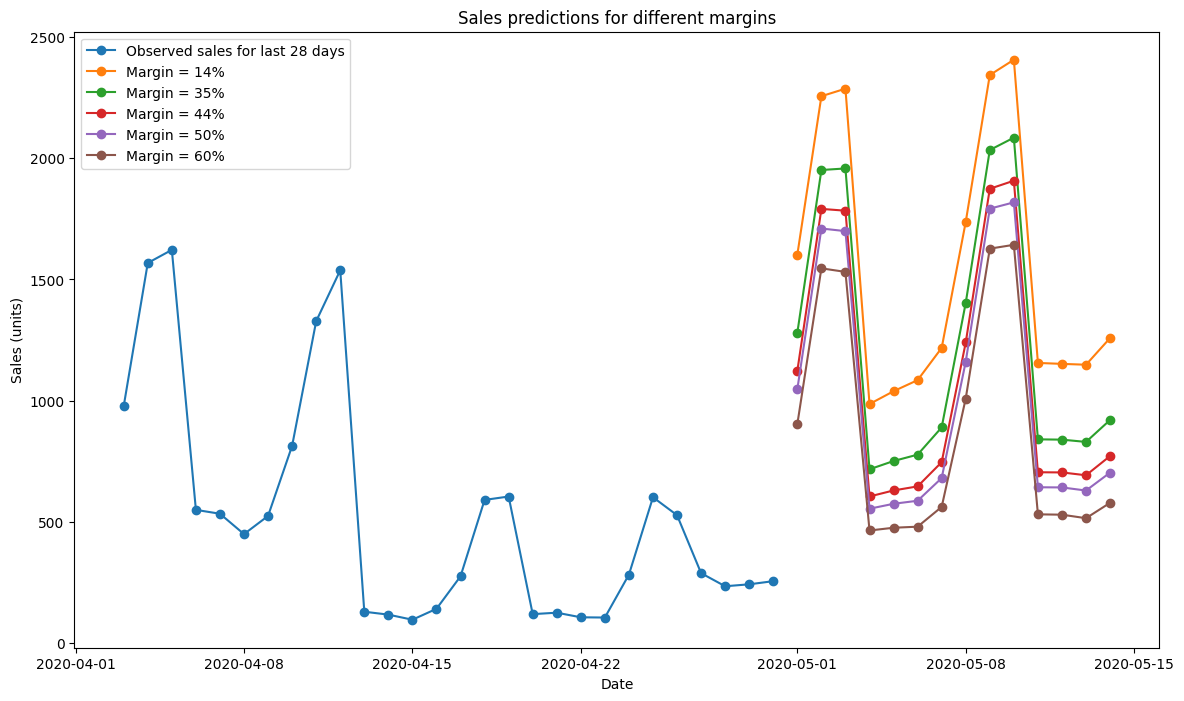

In [62]:
#@title
#Pick a random product_id from the test data, and visualize predicted sales for various margins
margins_to_eval = [1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]
plot_margins = [1.15, 1.35, 1.45, 1.5, 1.6]
plt.figure(figsize=(14,8))
plt.plot(X1['date'], X1['sales'], 'o-', label="Observed sales for last 28 days")
max_sales = 0
max_profits = 0
for margin in margins_to_eval:
    X2['price'] = margin
    X1_input = preprocessor.transform(X1).toarray()
    X2_input = preprocessor.transform(X2).toarray()
    y = X2_input[:,2]
    X2_input = np.delete(X2_input, 2, axis=1)
    X1_input = np.expand_dims(X1_input, axis=0)
    X2_input = np.expand_dims(X2_input, axis=0)
    py = encoder_decoder_model.predict([X1_input, X2_input], verbose=0)

    #Sales were scaled using the min max scaler, changing it back to original scale
    X2[f'predicted_{margin}'] = (py[0]*(preprocessor.named_transformers_['num'].data_max_[-1]-preprocessor.named_transformers_['num'].data_min_[-1])) + preprocessor.named_transformers_['num'].data_min_[-1] 
    X2[f'profit_{margin}'] = (X2['price'] - 1.0)*X2['cost']*X2[f'predicted_{margin}']
    if np.max(X2[f'predicted_{margin}']) > max_sales:
      max_sales = np.max(X2[f'predicted_{margin}'])
    
    if np.max(X2[f'profit_{margin}']) > max_profits:
      max_profits = np.max(X2[f'profit_{margin}'])

    if margin in plot_margins:
      plt.plot(X2['date'], X2[f'predicted_{margin}'], 'o-', label=f"Margin = {int((margin-1)*100)}%")
plt.title('Sales predictions for different margins')
plt.xlabel('Date')
plt.ylabel('Sales (units)')
plt.legend()
plt.show()

<h3> SALES AND PROFIT FOR VARIOUS PRICE POINTS, FORECAST FOR THE 6 DAYS </h3>

Text(0.5, 0.98, 'Sales and Profit (vs) Price for 6 days using model demand forecasts')

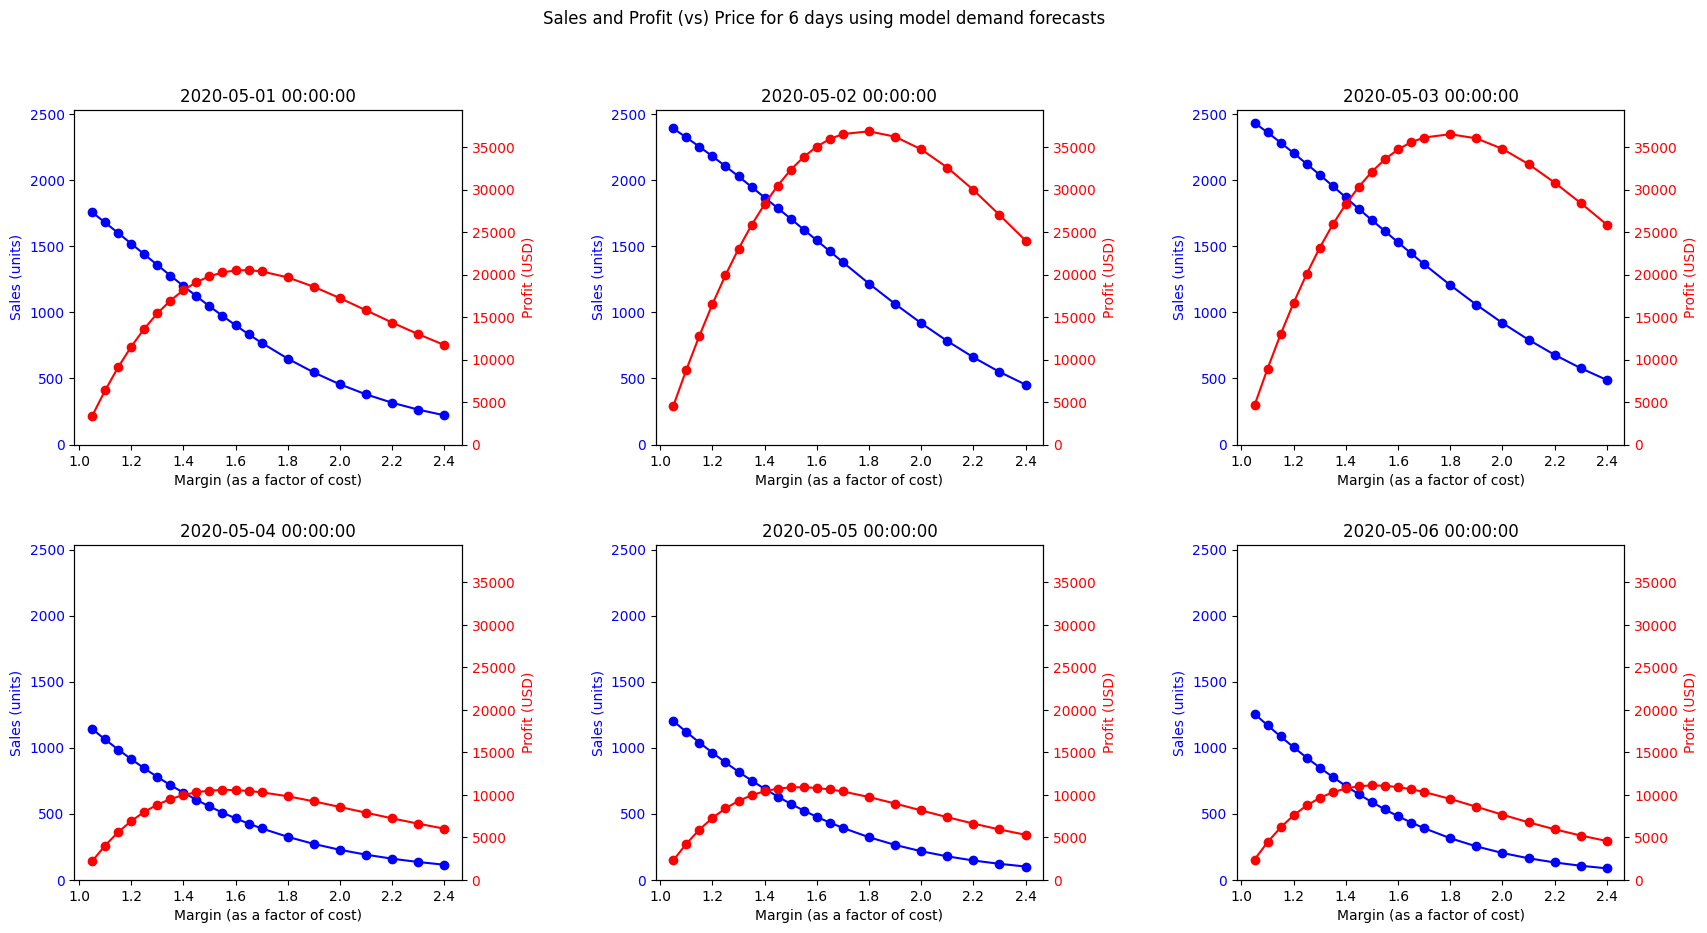

In [63]:
#@title
fig_size = (20, 10)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=fig_size)
plt.subplots_adjust(wspace=0.5, hspace=0.3)
c = 0
r = 0
dates = []
best_margins = []
for i in range(6):
  sales = []
  profits = []
  for margin in margins_to_eval:
    sales.append(X2.iloc[i][f'predicted_{margin}'])
    profits.append(X2.iloc[i][f'profit_{margin}'])
  
  dates.append(X2.iloc[i]['date'])
  best_margins.append(margins_to_eval[np.argmax(profits)])

  axs[c, r].set_xlabel("Margin (as a factor of cost)")
  axs[c, r].set_ylabel("Sales (units)", color='b')
  axs[c, r].tick_params(axis='y', labelcolor='b')
  axs[c, r].set_title(str(X2.iloc[i]['date']))
  
  # Plot sales
  axs[c, r].plot(margins_to_eval, sales, "o-", color='b', label="Sales (units)")
  axs[c, r].set_ylim([0, max_sales])

  # Plot profit
  ax2 = axs[c, r].twinx() 
  ax2.set_ylabel("Profit (USD)", color='r') 
  ax2.tick_params(axis='y', labelcolor='r')
  ax2.set_ylim([0, max_profits])
  #
  ax2.plot(margins_to_eval, profits, "o-", color='r', label="Profit (USD)")

  r += 1
  if r>2:
    r = 0
    c += 1

fig.suptitle('Sales and Profit (vs) Price for 6 days using model demand forecasts')


<h3> OPTIMAL PRICE FOR EACH OF THE NEXT 6 DAYS </h3>

Text(0, 0.5, 'Price as a factor of cost')

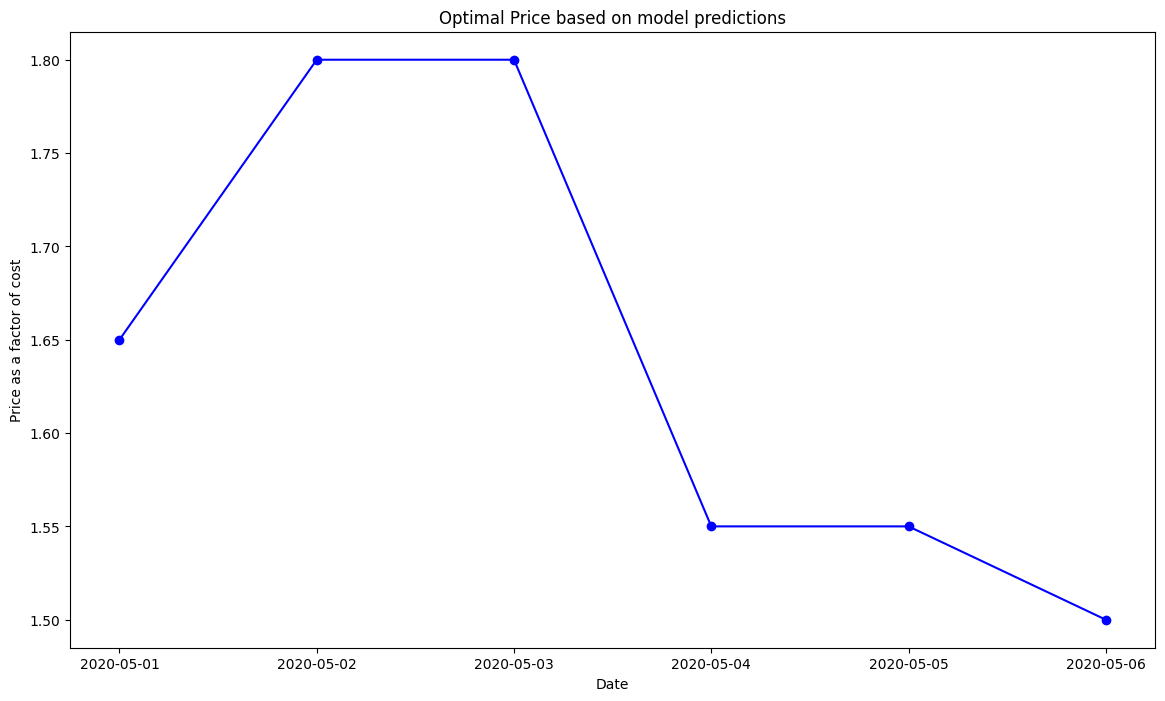

In [64]:
#@title
plt.figure(figsize=(14,8))
plt.plot(dates, best_margins, "o-", c='b')
plt.title('Optimal Price based on model predictions')
plt.xlabel('Date')
plt.ylabel('Price as a factor of cost')